# Script to tune the hyperparameters of the model (Diatom)

## Importing

In [86]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import root_mean_squared_error as rmse

from tqdm import tqdm

import dill
import random

import salishsea_tools.viz_tools as sa_vi

## Datasets Preparation

## Training 

In [163]:
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_model_var_old.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')
ds3 = xr.open_dataset('/data/ibougoudis/MOAD/files/clustering_diatom_sorted.nc')

ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(time_counter = (np.arange(0, len(ds2.time_counter),2)), 
    y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

ds3 = ds3.isel(time_counter = (np.arange(0, len(ds3.time_counter),2)), 
    y=(np.arange(ds3.y[0], ds3.y[-1], 5)), 
    x=(np.arange(ds3.x[0], ds3.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007-2-15', '2009-2-15'))
dataset2 = ds2.sel(time_counter = slice('2007-2-15', '2009-2-15'))
dataset3 = ds3.sel(time_counter = slice('2007-2-15', '2009-2-15'))

drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), 
    np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)']),
    np.ravel(dataset2['Summation_of_solar_radiation']),
    np.ravel(dataset2['Mean_wind_speed']),
    np.ravel(dataset2['Mean_air_temperature'])
    ])
indx = np.where(~np.isnan(drivers).any(axis=0))
drivers = drivers[:,indx[0]]

diat = np.ravel(dataset['Diatom'])
diat = diat[indx[0]]

cluster = np.ravel(dataset3['Clusters_Diatom_Sorted'])
cluster = cluster[indx[0]]

drivers = drivers.transpose()

drivers[0]

array([  8.52399445,   8.59896278,  28.21989632,  28.40815926,
       827.51515118,   6.34831744, 282.49785799])

In [ ]:

time_ordinal = [pd.to_datetime(x).toordinal() for x in ds.time_counter.values]
time_ordinal

In [164]:
from sklearn.neural_network import MLPRegressor
regr_all = []
for i in range (0,6):
    indx2 = np.where(cluster==i)
    drivers2 = drivers[indx2[0]]
    diat2 = diat[indx2]
    model = TransformedTargetRegressor(regressor=make_pipeline(StandardScaler(),
    MLPRegressor(alpha=0.001, learning_rate='invscaling', epsilon=1e-07)), 
        transformer=StandardScaler())
    regr = model.fit(drivers2,diat2)
    regr_all.append(regr)

/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

In [165]:
dataset = ds.sel(time_counter = slice('2023-4-20', '2023-4-20'))
dataset2 = ds2.sel(time_counter = slice('2023-4-20', '2023-4-20'))
dataset3 = ds3.sel(time_counter = slice('2023-4-20', '2023-4-20'))

drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), 
    np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)']),
    np.ravel(dataset2['Summation_of_solar_radiation']),
    np.ravel(dataset2['Mean_wind_speed']),
    np.ravel(dataset2['Mean_air_temperature'])
    ])
indx = np.where(~np.isnan(drivers).any(axis=0))
drivers = drivers[:,indx[0]]

diat = np.ravel(dataset['Diatom'])
diat = diat[indx[0]]

cluster = np.ravel(dataset3['Clusters_Diatom_Sorted'])
cluster = cluster[indx]

drivers = drivers.transpose()

In [166]:
out = []
for i in range (0,6):
    indx2 = np.where(cluster==i)
    drivers2 = drivers[indx2[0]]
    diat2 = diat[indx2]
    out.append(regr_all[i].predict(drivers2))

In [167]:
test = np.full(len(indx[0]),np.nan)
indx3 = np.full((len(dataset.y)*len(dataset.x)),np.nan)
for i in range (0,6):
    indx2 = np.where(cluster==i)
    test[indx2] = out[i]
indx3[indx[0]]= test
model = np.reshape(indx3,(len(dataset.y),len(dataset.x)))
# Preparation of the dataarray 
model = xr.DataArray(model,
    coords = {'y': dataset.y, 'x': dataset.x},
    dims = ['y','x'],
    attrs=dict( long_name = "Concentration",
    units="mmol m-2"),)

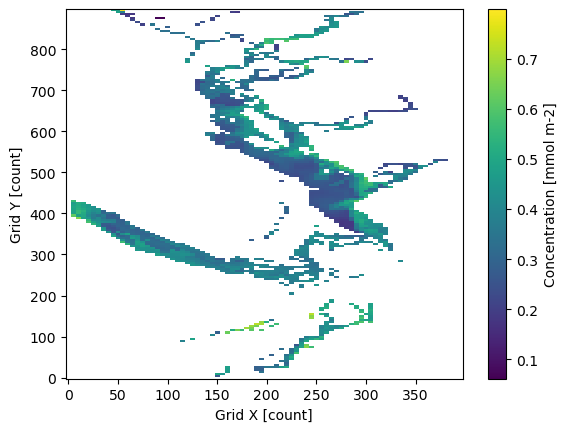

In [168]:
model.plot()

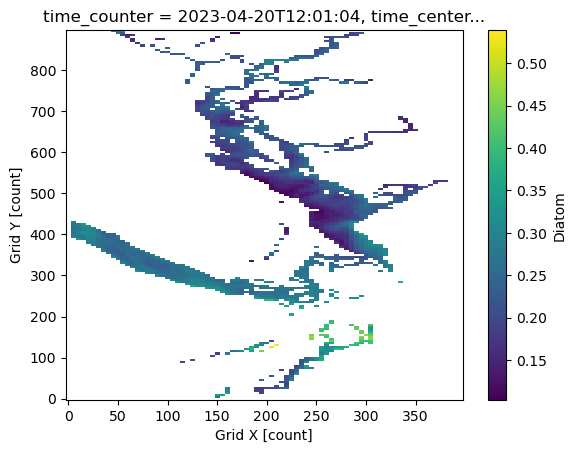

In [169]:
dataset.Diatom.plot()

In [170]:
temp = np.ravel(model)

In [171]:
temp = temp[indx[0]]

In [172]:
np.corrcoef(diat,temp)

array([[1.        , 0.69355136],
       [0.69355136, 1.        ]])